In [2]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
from sklearn.cluster import KMeans

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [68]:
segment_directory = "data/segmentation.csv"

segment = pd.read_csv(segment_directory, header=0 )


In [69]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


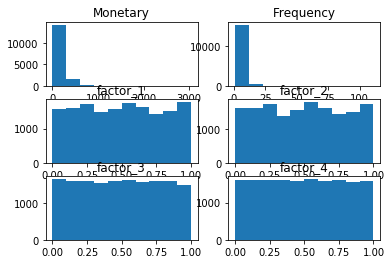

In [108]:
plt.subplot(321)
plt.hist(segment['Monetary'])
plt.title('Monetary')

plt.subplot(322)
plt.hist(segment['Frequency'])
plt.title('Frequency')

plt.subplot(323)
plt.hist(segment['factor_1'])
plt.title('factor_1')

plt.subplot(324)
plt.hist(segment['factor_2'])
plt.title('factor_2')

plt.subplot(325)
plt.hist(segment['factor_3'])
plt.title('factor_3')

plt.subplot(326)
plt.hist(segment['factor_4'])
plt.title('factor_4')

plt.show()

# 1. Обработка исходных данных
При просмотре данных обнаружено, что имеются значения типа datetime, которые не могут обрабатываться алгоритмами, поэтому необходимо привести их в некоторое числовое значение. Решено привести их к значению: за сколько дней до окончания периода пользователь проводил последнюю операцию. Таким образом, можно будет определить пользователей, которые были активны в начале или в конце периода (в данном случае не важно, считаем мы от конца периода или от начала, я решила выбрать от конца)

Более того, порядок значений отличается. Например, скрытые факторы меньше 1, а, например, Monetary исчисляется сотнями. Если мы оставим данные как они есть сейчас, то при кластерном анализе Monetary будет вносить больший вклад в расстояние, что может исказить картину. Поэтому нормализуем все значение путем деления на максимальное

In [70]:
# обработка даты
copy = pd.DataFrame(segment)
copy['Recency'] = pd.to_datetime(copy['Recency'])

maxd = copy['Recency'].max()
          
copy['Last'] = list((maxd - x).days for x in copy['Recency'])

data = pd.DataFrame(copy[['Monetary', 'Last', 'Frequency', 'factor_1', 'factor_2', 'factor_3', 'factor_4']])
data.head()
  

,Monetary,Last,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,12,6,0.35,0.08,0.609740,0.949383
1,170.00,22,4,0.66,0.16,0.942272,0.479846
2,70.75,22,6,0.92,0.20,0.323030,0.007076
3,75.00,88,10,0.35,0.78,0.876833,0.088974
4,94.51,67,5,0.51,0.44,0.912099,0.206194


In [71]:
# нормализация переменных - деление на max
сopy = data.copy()
for feature in list(data):
    max_value = data[feature].max()
    data[feature] = list(x/max_value for x in data[feature])
    
data.head()

,Monetary,Last,Frequency,factor_1,factor_2,factor_3,factor_4
0,0.033026,0.072289,0.054054,0.35,0.08,0.609742,0.949437
1,0.055921,0.132530,0.036036,0.66,0.16,0.942276,0.479873
2,0.023273,0.132530,0.054054,0.92,0.20,0.323032,0.007076
3,0.024671,0.530120,0.090090,0.35,0.78,0.876836,0.088979
4,0.031089,0.403614,0.045045,0.51,0.44,0.912103,0.206205


# 2. Понижение размерности методом PCA
Мы используем многомерное просранство, но для упрощения работы можно привести его к более привычному трехмерному пространству метдом главных компонент

In [72]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data.values)
data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 
data['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21942921 0.19627939 0.19285506]


В новом трехмерном пространстве пользователи будут распределены следующим образом:

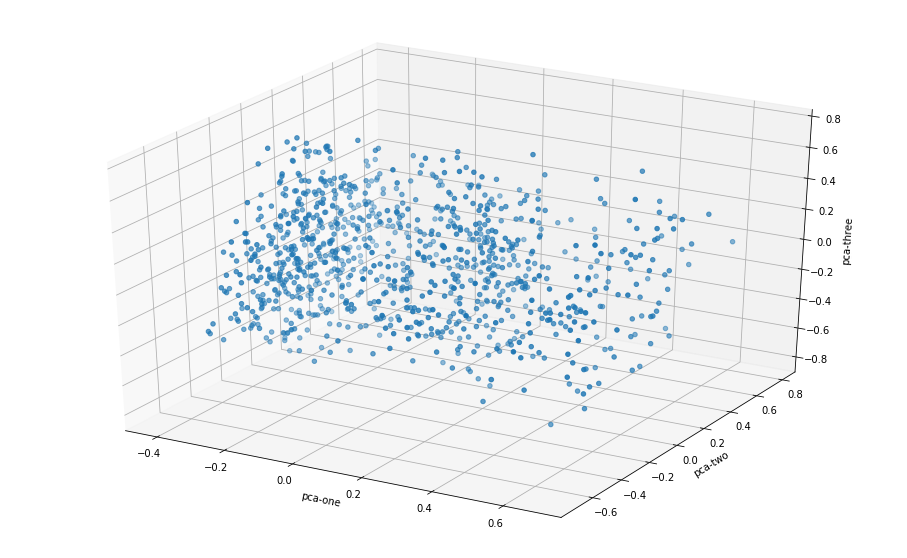

In [73]:
rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=data.loc[rndperm,:]["pca-one"], 
    ys=data.loc[rndperm,:]["pca-two"], 
    zs=data.loc[rndperm,:]["pca-three"], 
    
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# 3. Определение типов пользователей
Будем определять пользователей путем кластерного анализа

In [9]:
from datetime import datetime
from sklearn.cluster import KMeans

Признаков не много, поэтому нет необходимости в большом количестве кластеров. К тому же, большое количество кластеров анализировать сложнее. Попробуем собрать данные в 2, 3, 4 и 5 кластеров

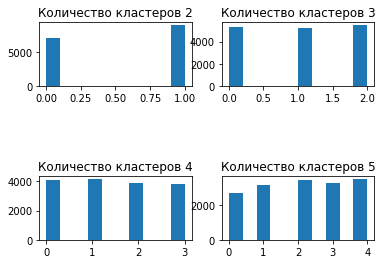

In [74]:
clusters = {}
cluster_data = pd.DataFrame(data[['pca-one', 'pca-two', 'pca-three']])

for n_clust in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=n_clust).fit(cluster_data)
    
    predict = kmeans.predict(cluster_data)
    clusters[n_clust] = predict

    
plt.subplot(321)
plt.hist(clusters[2])
plt.title('Количество кластеров 2')


plt.subplot(322)
plt.hist(clusters[3])
plt.title('Количество кластеров 3')

plt.subplot(325)
plt.hist(clusters[4])
plt.title('Количество кластеров 4')

plt.subplot(326)
plt.hist(clusters[5])
plt.title('Количество кластеров 5')

plt.show()
    
#pd.tools.plotting.parallel_coordinates(data, 'cluster')


 Алгоритм равномерно распределяет по любому из выбранного количества кластеров, поэтому попробуем рассмотреть 3 кластера на более обобщенном уровне

In [75]:
n_cluster = 3

In [76]:
cluster_data['cluster'] = clusters[n_cluster]

In [98]:
def get_plot(x):
    rndperm = list(range(1,500))
    
    clust =  pd.DataFrame(cluster_data.loc[cluster_data['cluster']==0])
    trace0 = go.Scatter3d(
        x = clust.loc[rndperm,:][x[0]],
        y = clust.loc[rndperm,:][x[1]],
        z = clust.loc[rndperm,:][x[2]],
        name = 'Cluster 1',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgba(152, 0, 0, .8)',
            line = dict(
                width = 0,
            )
        )
    )

    clust = pd.DataFrame(cluster_data.loc[cluster_data['cluster']==1])
    trace1 = go.Scatter3d(
        x = clust.loc[rndperm,:][x[0]],
        y = clust.loc[rndperm,:][x[1]],
        z = clust.loc[rndperm,:][x[2]],
        name = 'Cluster 2',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgba(255, 182, 193, .9)',
            line = dict(
                width = 0,
                 color = 'rgba(0, 0, 0, 0)'
        
            )
        )
    )
    
    
    clust = pd.DataFrame(cluster_data.loc[cluster_data['cluster']==2])
    trace2 = go.Scatter3d(
        x = clust.loc[rndperm,:][x[0]],
        y = clust.loc[rndperm,:][x[1]],
        z = clust.loc[rndperm,:][x[2]],
        name = 'Cluster 3',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgba(127, 182, 127, .9)',
            line = dict(
            width = 0,
            )
        )
    )
    
    graph_data = [trace0, trace1, trace2]
    layout = dict(title = 'Полученные кластеры \n x - {0}, y = {1}, z - {2}'.format(x[0], x[1], x[2]),
                  yaxis = dict(title=x[1], zeroline = False),
                  xaxis = dict(title=x[0], zeroline = False)
                 )

    fig = dict(data=graph_data, layout=layout)
    iplot(fig, filename='styled-scatter')

В трехмерном пространстве распределение пользователей выглядит следующим образом (график можно масштабировать и вращать). Однако значения pca были вычислены и не имеют практической применимости при анализе полученных кластеров, поэтому необходимо вернуться к исходным данным и на их примере более подробно проанализировать полученные группы пользователей

In [78]:
get_plot(['pca-one', 'pca-two', 'pca-three'])

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



# 4. Анализ типов пользователей

In [79]:
# вернемся к исходным ненормализованным значениям для анализа 
cluster_data = pd.DataFrame(copy[['Monetary', 'Last', 'Frequency', 'factor_1', 'factor_2', 'factor_3', 'factor_4']])
cluster_data['cluster'] = clusters[n_cluster]
cluster_data.head()

,Monetary,Last,Frequency,factor_1,factor_2,factor_3,factor_4,cluster
0,100.40,12,6,0.35,0.08,0.609740,0.949383,0
1,170.00,22,4,0.66,0.16,0.942272,0.479846,0
2,70.75,22,6,0.92,0.20,0.323030,0.007076,0
3,75.00,88,10,0.35,0.78,0.876833,0.088974,2
4,94.51,67,5,0.51,0.44,0.912099,0.206194,1


Cluster  1
Mean 157.93156782039256
Median 85.0
Max 3040.0
Min 0.0
Std 206.13207465656458

Cluster  2
Mean 77.84339162182937
Median 31.84
Max 1364.0
Min 0.0
Std 118.96670185407429

Cluster  3
Mean 152.3234232250964
Median 82.07
Max 2065.0
Min 1.08
Std 189.40725592018669



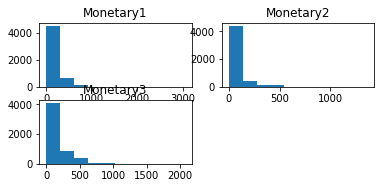

In [101]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('Monetary' + str(cluster+1))
    plt.hist(objects['Monetary'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['Monetary'].mean()))
    print('Median {}'.format(np.median(objects['Monetary'])))
    print('Max {}'.format(objects['Monetary'].max()))
    print('Min {}'.format(objects['Monetary'].min()))
    print('Std {}'.format(objects['Monetary'].std()))
    print()
plt.show()

Cluster  1
Mean 4.767259120673526
Median 3.0
Max 111
Min 1
Std 5.950904273012921

Cluster  2
Mean 2.412567255956956
Median 1.0
Max 61
Min 1
Std 2.8124547311440122

Cluster  3
Mean 4.618418638781875
Median 3.0
Max 94
Min 1
Std 5.782261878764737



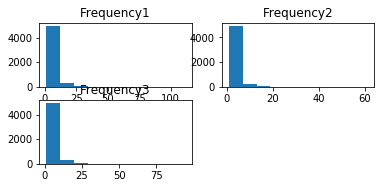

In [102]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('Frequency' + str(cluster+1))
    plt.hist(objects['Frequency'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['Frequency'].mean()))
    print('Median {}'.format(np.median(objects['Frequency'])))
    print('Max {}'.format(objects['Frequency'].max()))
    print('Min {}'.format(objects['Frequency'].min()))
    print('Std {}'.format(objects['Frequency'].std()))
    print()
    
plt.show()

Cluster  1
Mean 27.94087932647334
Median 18.0
Max 118
Min 0
Std 27.6811173651449

Cluster  2
Mean 119.55630284396618
Median 117.0
Max 166
Min 60
Std 29.552119928805755

Cluster  3
Mean 31.298477343606677
Median 21.0
Max 118
Min 0
Std 30.10572616861799



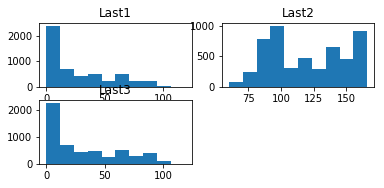

In [103]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('Last' + str(cluster+1))
    plt.hist(objects['Last'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['Last'].mean()))
    print('Median {}'.format(np.median(objects['Last'])))
    print('Max {}'.format(objects['Last'].max()))
    print('Min {}'.format(objects['Last'].min()))
    print('Std {}'.format(objects['Last'].std()))
    print()
    
plt.show()


Cluster  1
Mean 0.5299139382600578
Median 0.54
Max 1.0
Min 0.0
Std 0.28835545744358626

Cluster  2
Mean 0.49297655649500327
Median 0.49
Max 1.0
Min 0.0
Std 0.2890881809875308

Cluster  3
Mean 0.4773968079251518
Median 0.47
Max 1.0
Min 0.0
Std 0.2904781760674281



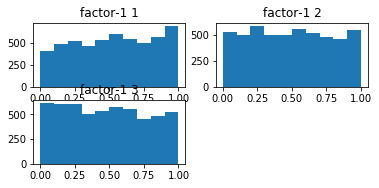

In [104]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('factor-1 ' + str(cluster+1))
    plt.hist(objects['factor_1'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['factor_1'].mean()))
    print('Median {}'.format(np.median(objects['factor_1'])))
    print('Max {}'.format(objects['factor_1'].max()))
    print('Min {}'.format(objects['factor_1'].min()))
    print('Std {}'.format(objects['factor_1'].std()))
    print()
    
plt.show()

Cluster  1
Mean 0.2643143124415318
Median 0.24
Max 0.87
Min 0.0
Std 0.1823881578155717

Cluster  2
Mean 0.47381437355880085
Median 0.48
Max 1.0
Min 0.0
Std 0.2680586970342691

Cluster  3
Mean 0.7498312236286865
Median 0.77
Max 1.0
Min 0.18
Std 0.17320944776112343



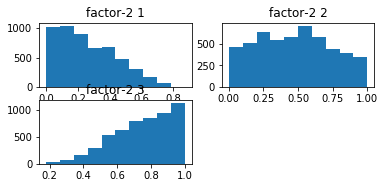

In [105]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('factor-2 ' + str(cluster+1))
    plt.hist(objects['factor_2'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['factor_2'].mean()))
    print('Median {}'.format(np.median(objects['factor_2'])))
    print('Max {}'.format(objects['factor_2'].max()))
    print('Min {}'.format(objects['factor_2'].min()))
    print('Std {}'.format(objects['factor_2'].std()))
    print()
    
plt.show()

Cluster  1
Mean 0.3989381982519297
Median 0.3564195020186152
Max 0.999491237806246
Min 0.00013636603014632875
Std 0.2755758147613876

Cluster  2
Mean 0.5154837174607584
Median 0.5261105199943079
Max 0.9999924238957356
Min 0.0001758478100923888
Std 0.2847324067460465

Cluster  3
Mean 0.5709611508510881
Median 0.6032755367286056
Max 0.999995926080402
Min 3.711333357880875e-05
Std 0.27956681002591016



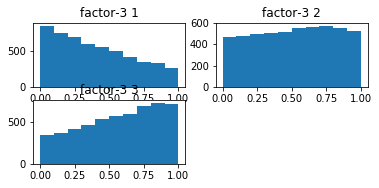

In [106]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('factor-3 ' + str(cluster+1))
    plt.hist(objects['factor_3'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['factor_3'].mean()))
    print('Median {}'.format(np.median(objects['factor_3'])))
    print('Max {}'.format(objects['factor_3'].max()))
    print('Min {}'.format(objects['factor_3'].min()))
    print('Std {}'.format(objects['factor_3'].std()))
    print()
    
plt.show()

Cluster  1
Mean 0.4426170428861119
Median 0.4161056623972378
Std 0.28606887106828033

Cluster  2
Mean 0.496489435724115
Median 0.4978391808902882
Std 0.286805265271113

Cluster  3
Mean 0.5550011804146799
Median 0.5756244908184834
Std 0.2815433916341491



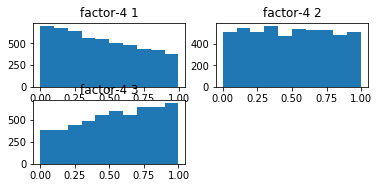

In [107]:
for cluster in range(0, n_cluster):
    objects= cluster_data.loc[cluster_data['cluster'] == cluster]
    
    plt.subplot(321+cluster)
    plt.title('factor-4 ' + str(cluster+1))
    plt.hist(objects['factor_4'])
    
    print('Cluster ', str(cluster+1))
    print('Mean {}'.format(objects['factor_4'].mean()))
    print('Median {}'.format(np.median(objects['factor_4'])))
    print('Std {}'.format(objects['factor_4'].std()))
    print()
    
plt.show()

На основе полученных средних значений признаков обнаружено, что признак factor_4 имеет приблизительно одинаковое значение на всех кластерах, как же как и признак factor_1. Значит, они не оказывают существенное влияние на определение типа пользователя. Картина распределения значений Monetary и Freqency практически одинаковы в разных кластерах, поэтому визуализация кластеров в пространстве этих признаков приведет к смешению элементов. 
В результате можно попробовать рассмотреть кластеры в пространстве Last, factor_2 и factor_3

In [93]:
get_plot(['factor_2', 'factor_3', 'Last'])

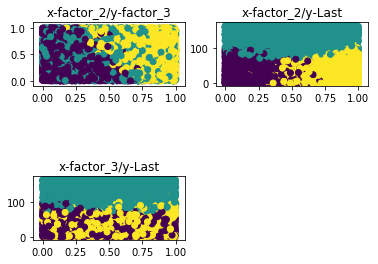

In [97]:
# Разделение набора данных
x_axis = cluster_data['factor_2']
y_axis = cluster_data['factor_3']
 
# Построение
plt.subplot(321)
plt.title('x-factor_2/y-factor_3')
plt.scatter(x_axis, y_axis, c=cluster_data['cluster'])

x_axis = cluster_data['factor_2']
plt.subplot(322)
plt.title('x-factor_2/y-Last')
y_axis=cluster_data['Last']
plt.scatter(x_axis, y_axis, c=cluster_data['cluster'])

x_axis = cluster_data['factor_3']
plt.subplot(325)
plt.title('x-factor_3/y-Last')
plt.scatter(x_axis, y_axis, c=cluster_data['cluster'])


plt.show()

В результате проекции на двумерное пространство обнаружено, что наиболее четкая картина образуется при провере признаков Last и factor_2. То есть, эти два признака позволят разделить категории пользователей

# 5. Определение характеристик пользователей

## 5.1. Cluster 2

Если расмотреть наиболее выделяющийся кластер пользователей (cluster 2 с большим показателем Last), то можно обнаружить, что они были активны только в начале периода (чем больше Last, тем ближе активность к началу периода), это подтверждатся маленькой частотой платежей. Также у них меньше объем принесенных средств. Таким образом, можно сказать, что это пользователи, которые, например, решили попробовать услугу в начале периода, но затем они перестали этой услугой пользоваться. Назовем их Испытателями

## 5.2. Cluster 1 и Cluster 3
Эти категории пользователей скорее всего были с нами с начала и до конца периода (судя по частоте платежей и дате последнего платежа). Именно поэтому, по сути, по внешним факторам они не особо отличаются: примерно одинаковая частота платежей и объем внесенных средств. Однако по скрытым факторам эти типы существенно отличаются. Так, по признакам factor_2 и factor_3 разница почти в 3 и 1,5 раза соответственно, также по fаctor_4 первый тип уступает второму. К сожалению, суть этих признаков от меня скрыта, поэтому более ясну картину сделать не удается.